In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Tải dữ liệu từ file CSV
data = pd.read_csv('data/data.csv', parse_dates=['Date'], index_col='Date')

# Xem qua dữ liệu
print(data.head())

# Chỉ sử dụng cột 'Adj Close' cho mô hình
values = data['Adj Close'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

# Phân chia dữ liệu thành 60% train, 20% validation, 20% test
train_size = int(len(scaled_values) * 0.60)
val_size = int(len(scaled_values) * 0.20)
test_size = len(scaled_values) - train_size - val_size

train, val, test = scaled_values[:train_size], scaled_values[train_size:train_size + val_size], scaled_values[train_size + val_size:]

# Kiểm tra kích thước của các tập dữ liệu
print(f"Train: {train.shape}, Validation: {val.shape}, Test: {test.shape}")


            Open  High   Low  Close  Adj Close  Volume
Date                                                  
1960-01-04  4.52  4.52  4.52   4.52       4.52       0
1960-01-05  4.55  4.55  4.55   4.55       4.55       0
1960-01-06  4.68  4.68  4.68   4.68       4.68       0
1960-01-07  4.63  4.63  4.63   4.63       4.63       0
1960-01-08  4.59  4.59  4.59   4.59       4.59       0
Train: (9737, 1), Validation: (3245, 1), Test: (3247, 1)


In [9]:
# Naïve Forecast: Dự báo giá trị gần nhất
naive_forecast = np.roll(train, shift=-1)
naive_forecast[-1] = train[-1]  # Điều chỉnh giá trị cuối cùng

# Dự báo cho tập test (Naïve: dự báo luôn bằng giá trị cuối của training)
naive_predictions = np.full_like(test, fill_value=train[-1])


In [13]:
test.shape

(3247, 1)

In [11]:
naive_predictions.shape

(9737, 1)

In [4]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Holt-Winters Exponential Smoothing (Triple Exponential Smoothing)
holt_winters_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
holt_winters_model_fit = holt_winters_model.fit()

# Dự báo trên tập validation và test
holt_winters_forecast = holt_winters_model_fit.forecast(len(test))

# Lưu lại mô hình
holt_winters_model_fit.save('holt_winters_model.pkl')


In [5]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA Model (p, d, q)
arima_model = ARIMA(train, order=(5,1,0))  # Cấu hình p=5, d=1, q=0
arima_model_fit = arima_model.fit()

# Dự báo trên tập validation và test
arima_forecast = arima_model_fit.forecast(len(test))

# Lưu lại mô hình
arima_model_fit.save('arima_model.pkl')


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm

# Dự báo trên tập test
naive_predictions = np.roll(train, shift=-1)
naive_predictions[-1] = train[-1]

# Holt-Winters Predictions
holt_winters_predictions = holt_winters_model_fit.forecast(len(test))

# ARIMA Predictions
arima_predictions = arima_model_fit.forecast(len(test))

# Tính MAE và RMSE
def evaluate_model(test, forecast):
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    return mae, rmse

# Đánh giá các mô hình
# mae_naive, rmse_naive = evaluate_model(test, naive_predictions)
mae_hw, rmse_hw = evaluate_model(test, holt_winters_predictions)
mae_arima, rmse_arima = evaluate_model(test, arima_predictions)

# print(f"Naïve: MAE={mae_naive}, RMSE={rmse_naive}")
print(f"Holt-Winters: MAE={mae_hw}, RMSE={rmse_hw}")
print(f"ARIMA: MAE={mae_arima}, RMSE={rmse_arima}")

# Kiểm tra AIC, BIC cho ARIMA
print(f"ARIMA: AIC={arima_model_fit.aic}, BIC={arima_model_fit.bic}")


Holt-Winters: MAE=0.18822668501641687, RMSE=0.20446679967278417
ARIMA: MAE=0.18900306989928048, RMSE=0.2055131083719131
ARIMA: AIC=-71663.2304571436, BIC=-71620.12894333559


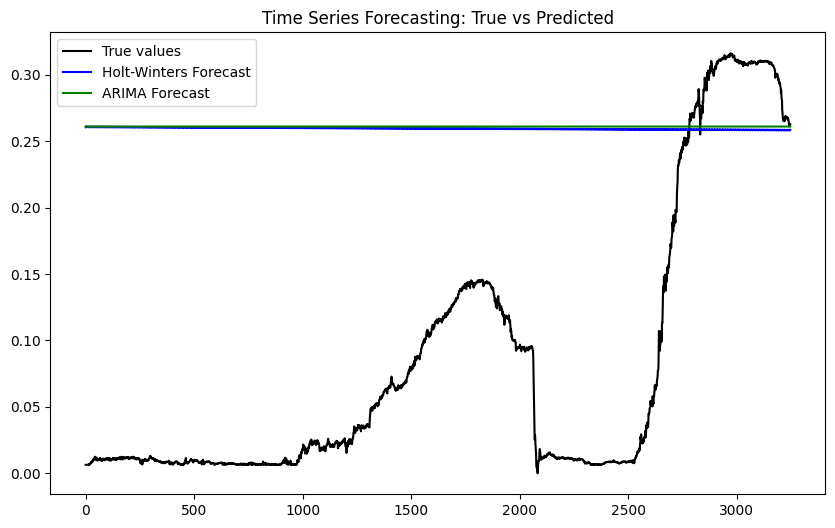

In [15]:
# Tạo một biểu đồ để so sánh các dự báo với dữ liệu thực tế
plt.figure(figsize=(10,6))
plt.plot(test, label='True values', color='black')
# plt.plot(naive_predictions, label='Naïve Forecast', color='red')
plt.plot(holt_winters_predictions, label='Holt-Winters Forecast', color='blue')
plt.plot(arima_predictions, label='ARIMA Forecast', color='green')
plt.legend(loc='upper left')
plt.title('Time Series Forecasting: True vs Predicted')
plt.show()


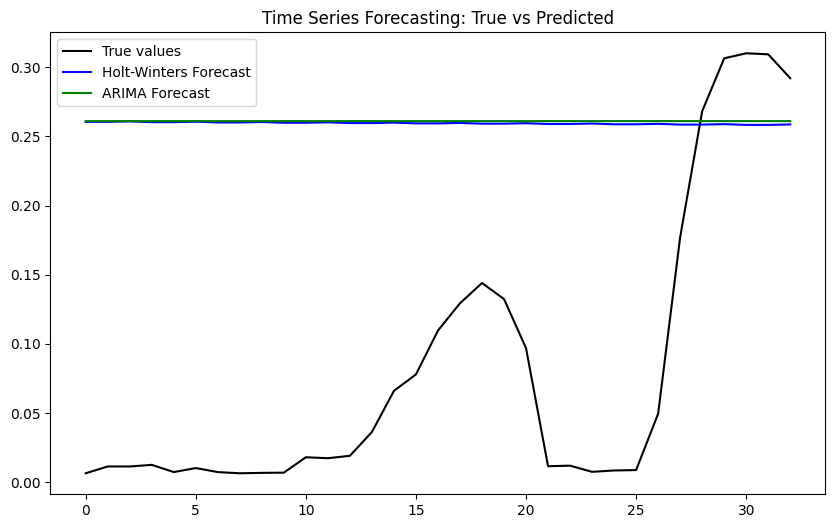

In [18]:
# Giảm bớt số lượng điểm hiển thị trên đồ thị (ví dụ, chỉ hiển thị mỗi 10 điểm)
plt.figure(figsize=(10, 6))
plt.plot(test[::100], label='True values', color='black')  # Chỉ lấy mỗi 100 điểm
# plt.plot(naive_predictions[::100], label='Naïve Forecast', color='red')
plt.plot(holt_winters_predictions[::100], label='Holt-Winters Forecast', color='blue')
plt.plot(arima_predictions[::100], label='ARIMA Forecast', color='green')
plt.legend(loc='upper left')
plt.title('Time Series Forecasting: True vs Predicted')
plt.show()
